In [1]:
import sys
sys.path.append("../../")

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
#from classy import Class

In [5]:
from axion_kSZ_source.axion_camb_wrappers.run_axion_camb import AxionCAMBWrapper
from axion_kSZ_source.theory.cosmology import Cosmology,CosmologyCustomH
from axion_kSZ_source.theory.sigma_interpolation import SigmaInterpolator
from axion_kSZ_source.theory.sigma_interpolation_FFTLog import SigmaInterpolatorFFTLog
from axion_kSZ_source.auxiliary.integration_helper import IntegrationHelper
from axion_kSZ_source.auxiliary.window_functions import WindowFunctions
from axion_kSZ_source.theory.mass_functions import PressSchechterMassFunction
from axion_kSZ_source.theory.halo_bias_new import HaloBias
from axion_kSZ_source.theory.correlation_functions import CorrelationFunctions
from axion_kSZ_source.theory.correlation_functions_FFTLog import CorrelationFunctions as CorrelationFunctionsFFTLog

In [13]:
#cosmo = CosmologyCustomH.generate(h=0.50)
cosmoDefault = Cosmology.generate(m_axion=1.e-26, axion_frac=0.5,h=0.72)
cosmoDefault2 = Cosmology.generate(m_axion=1.e-26,axion_frac=0.1,h=0.72)

In [ ]:
outpath = "./sigma_tests/"
fileroot ="test"
log_path = outpath+"sigma_test_log.log"

camb = AxionCAMBWrapper(outpath, fileroot, log_path)
fileroot ="test2"
log_path = outpath+"sigma_test2_log.log"
camb2 = AxionCAMBWrapper(outpath, fileroot, log_path)

camb(cosmoDefault)
camb2(cosmoDefault2)

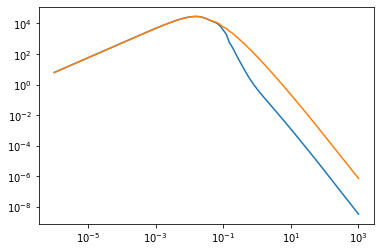

In [12]:
lin_power = camb.get_linear_power(extrap_kmax=1e3, extrap_kmin=1e-6)
lin2_power = camb2.get_linear_power(extrap_kmax=1e3, extrap_kmin=1e-6)

k_vals = np.logspace(-6, 3, 100)
plt.loglog(k_vals, lin_power(k_vals))
plt.loglog(k_vals, lin2_power(k_vals))

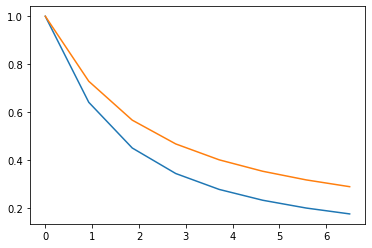

In [24]:
growth = camb.get_growth()
z_vals=np.linspace(0, 6.5, 8)
plt.plot(z_vals, growth(1e-2, z_vals))
plt.plot(z_vals, growth(1000, z_vals))

In [25]:
cosmo.set_H_interpolation(camb.get_hubble())

In [26]:
intHelper = IntegrationHelper(2048)

In [27]:
window="sharp_k"

In [28]:
sigmaInt = SigmaInterpolator(cosmo, lin_power, growth, 1e14, 1e16, z_vals, intHelper, Nr=1024, window_function=window)
sigmaInt.compute(1e-4, 1e3)

In [29]:
sigmaIntFFTLog = SigmaInterpolatorFFTLog(cosmo, lin_power, growth, z_vals, 1e-4, 1e3, Nr=1024, window_function=window)
sigmaIntFFTLog.compute()

/Users/dgrin/opt/miniconda3/lib/python3.8/site-packages/mcfit/mcfit.py:126: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "


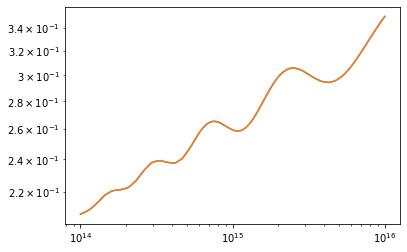

In [30]:
m_vals = np.logspace(14, 16, 100)
plt.loglog(m_vals, -sigmaInt.dlogSigma_dlogm(m_vals, 0.0))
plt.loglog(m_vals, -sigmaIntFFTLog.dlogSigma_dlogm(m_vals, 0.0))

In [31]:
ps_mass_function = PressSchechterMassFunction(cosmo, sigmaInt)
hbGW = HaloBias(cosmo, sigmaIntFFTLog, ps_mass_function, 1e14, 1e16, 1e-4, 1e1, z_vals, intHelper, Nk=1024, window_function="gaussian")
hbGW.compute_approximation()
hbTH = HaloBias(cosmo, sigmaIntFFTLog, ps_mass_function, 1e14, 1e16, 1e-4, 1e1, z_vals, intHelper, Nk=1024, window_function="top_hat")
hbTH.compute_approximation()
hbSK = HaloBias(cosmo, sigmaIntFFTLog, ps_mass_function, 1e14, 1e16, 1e-4, 1e1, z_vals, intHelper, Nk=1024, window_function="sharp_k")
hbSK.compute_approximation()

../../axion_kSZ_source/theory/halo_bias_base.py:31: RuntimeWarning: The given value of k_max=1.00E+01 is not feasible because you chose a sharp-k filter and a maximum mass of m_min=1.00E+14. k_max has instead be set to 3.55E-01
  warnings.warn(f"The given value of k_max={kMax:.2E} is not feasible because you chose a sharp-k filter and a maximum mass of m_min={mMin:.2E}. k_max has instead be set to {1 / self.radius_of_mass(mMin):.2E}", RuntimeWarning)


In [32]:
hb = HaloBias(cosmo, sigmaIntFFTLog, ps_mass_function, 1e14, 1e16, 1e-4, 1e1, z_vals, intHelper, Nk=1024, window_function="sharp_k")
hb.compute()

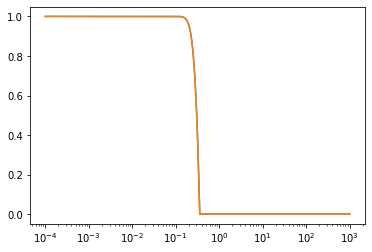

In [33]:
k_vals = np.logspace(-4, 3, 1000)
#plt.semilogx(k_vals, hbGW(k_vals, z_vals[0], 0.0))
#plt.semilogx(k_vals, hbTH(k_vals, z_vals[0], 0.0))
plt.semilogx(k_vals, hbSK(k_vals, z_vals[0], 0.0))
plt.semilogx(k_vals, hb(k_vals, z_vals[0], 0.0))


In [34]:
kMesh,zMesh,dump = np.meshgrid(k_vals, z_vals, np.ones((3)))
hb(kMesh, zMesh, 1.0).shape

(8, 1000, 3)

In [35]:
r_vals = np.linspace(1e-3, 200, 100)
corr = CorrelationFunctions(cosmo, lin_power, growth, hb, 1e-4, 1e3, z_vals, 1e-3, r_vals, intHelper)
dump = corr.compute(unbiased=True)

In [36]:
def compute_v(correlations):
    xi_unbiased, xi, dbarxi_dloga_unbiased, dbarxi_dloga =  correlations.get_correlation_functions(rMesh, zMesh, unbiased=True)
    v = r_vals * 100 * dbarxi_dloga / (3 * (1 + xi))
    v_dm = r_vals * 100 * dbarxi_dloga_unbiased / (3 * (1 + xi_unbiased))

    return v, v_dm

In [37]:
corrFFTLog = CorrelationFunctionsFFTLog(cosmo, lin_power, growth, hb, 1e-4, 1e3, z_vals, 1e-3, intHelper)
corrFFTLog.compute(unbiased=True)
corrFFTLogGW = CorrelationFunctionsFFTLog(cosmo, lin_power, growth, hbGW, 1e-4, 1e3, z_vals, 1e-3, intHelper)
corrFFTLogGW.compute(unbiased=True)
corrFFTLogTH = CorrelationFunctionsFFTLog(cosmo, lin_power, growth, hbTH, 1e-4, 1e3, z_vals, 1e-3, intHelper)
corrFFTLogTH.compute(unbiased=True)
corrFFTLogSK = CorrelationFunctionsFFTLog(cosmo, lin_power, growth, hbSK, 1e-4, 1e3, z_vals, 1e-3, intHelper)
corrFFTLogSK.compute(unbiased=True)

/Users/dgrin/opt/miniconda3/lib/python3.8/site-packages/mcfit/mcfit.py:217: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "


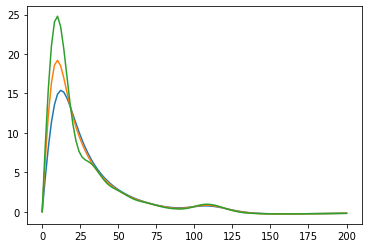

In [38]:
rMesh,zMesh=np.meshgrid(r_vals, z_vals)
plt.plot(r_vals, r_vals*corrFFTLogGW.get_correlation_functions(rMesh, zMesh, unbiased=True)[1][0])
plt.plot(r_vals, r_vals*corrFFTLogTH.get_correlation_functions(rMesh, zMesh, unbiased=True)[1][0])
plt.plot(r_vals, r_vals*corrFFTLogSK.get_correlation_functions(rMesh, zMesh, unbiased=True)[1][0])

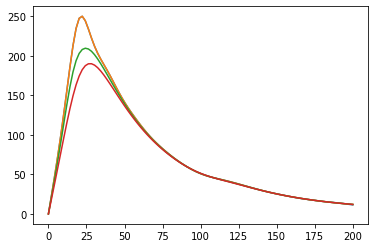

In [39]:
#plt.plot(r_vals, compute_v(corrFFTLog)[0][0]/compute_v(corrFFTLogSK)[0][0])
plt.plot(r_vals, compute_v(corr)[0][0])
plt.plot(r_vals, compute_v(corrFFTLogSK)[0][0])
plt.plot(r_vals, compute_v(corrFFTLogTH)[0][0])
plt.plot(r_vals, compute_v(corrFFTLogGW)[0][0])

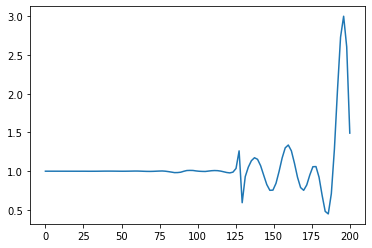

In [40]:
rMesh,zMesh = np.meshgrid(r_vals, z_vals)
fft_xi_lin, fft_xi, fft_out_dbarxi_dloga_lin, fft_out_dbarxi_dloga  = corrFFTLog.get_correlation_functions(rMesh, zMesh, unbiased=True)
xi_lin, xi, out_dbarxi_dloga_lin, out_dbarxi_dloga  = corr.get_correlation_functions(rMesh, zMesh, unbiased=True)
#plt.plot(r_vals, r_vals*fft_xi[0])
plt.plot(r_vals, xi[0]/fft_xi[0])
#plt.plot(r_vals, r_vals*xi[0])
#plt.plot(r_vals, r_vals*fft_xi_lin[0])
#plt.plot(r_vals, r_vals*xi_lin[0])

<ipython-input-41-4625c0b43631>:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(r_vals, fft_out_dbarxi_dloga[0]/out_dbarxi_dloga[0])


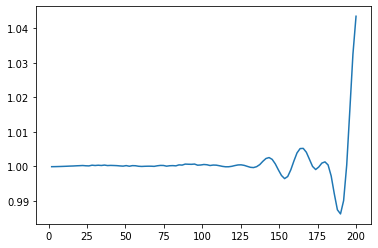

In [41]:
plt.plot(r_vals, fft_out_dbarxi_dloga[0]/out_dbarxi_dloga[0])
#plt.plot(r_vals, )
#plt.plot(r_vals, r_vals*fft_out_dbarxi_dloga_lin[0])
#plt.plot(r_vals, r_vals*out_dbarxi_dloga_lin[0])

In [42]:
r, lin_xi_fft, lin_dxi_fft, nonlin_xi_fft, nonlin_dxi_fft = corrFFTLog.compute_xi(z_vals, deriv=True, unbiased=True)

/Users/dgrin/opt/miniconda3/lib/python3.8/site-packages/mcfit/mcfit.py:217: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "


In [43]:
lin_xi, lin_dxi, nonlin_xi, nonlin_dxi = corr.compute_xi(r, z_vals, deriv=True, unbiased=True)

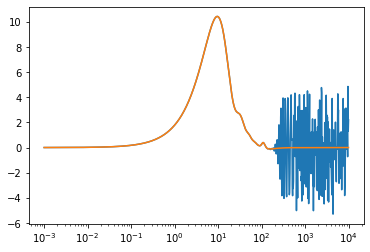

In [44]:
plt.semilogx(r, r*nonlin_dxi[0])
plt.semilogx(r, r*nonlin_dxi_fft[0])

In [45]:
1-nonlin_dxi[0]/nonlin_dxi_fft[0]

array([-1.38557303e-04, -1.33454904e-04, -1.38489804e-04, ...,
       -3.25786168e+07, -2.53109339e+06,  9.17287920e+05])

In [46]:
1-nonlin_xi[0]/nonlin_xi_fft[0]

array([-1.06953552e-04, -1.01773435e-04, -1.06885263e-04, ...,
       -3.25931425e+07, -2.66215585e+06,  8.84092970e+05])

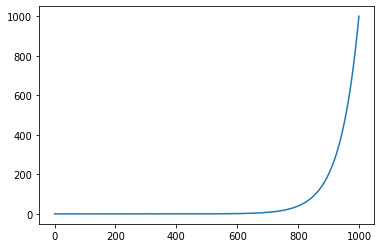

In [47]:
fig=plt.figure().add_subplot()

fig.plot(k_vals)